In [ ]:
!pip install --no-cache-dir qiskit
!pip install --no-cache-dir qiskit-Aer
!pip install ipykernel
!pip install matplotlib

In [2]:
from qiskit import *
from qiskit.visualization import *

Random walk

Random walk problem is going to involve a pair of coordinates (x, y).  On every turn of the walk, a person moves by 1 in a random direction - equivalently, one random coordinate changes by 1 in a random direction.  To implement this in a very classical sense, we can represent the coordinates as two registers of quantum bits and treat them like classical.

We can implement an "incrementer" on a quantum register by using a simplified adder - in this, there is no second addend, only a "carry" bit, initially one.  It is a string of half adders.

In [ ]:
def incrementup(num, carry, circuit): # Given a quantum register of some length
    
    circuit.initialize('01', carry) # Carry[1] (at left, initially 0) represents the next carry;
    # carry[0] (at right, initially 1) represents the input carry

    for i in range(len(num)):
        circuit.toffoli(carry[0], num[i], carry[1]) # Find the next carry - it's one iff both input carry and bit are one
        circuit.cnot(carry[0], num[i]) # Increment - change the value if there is carry
        circuit.swap(carry[0], carry[1]) # And next carry becomes new input carry
        circuit.initialize('0', carry[1]) # re-ground the carry bit - we want to know whether it should be one
    
myqr = QuantumRegister(4)
sum = ClassicalRegister(4)
carry = QuantumRegister(2)
myc = QuantumCircuit(myqr, sum, carry)
myc.initialize('0011', myqr) # Start with a value of b0011 = d3

incrementup(myqr, carry, myc) # increment twice
incrementup(myqr, carry, myc)

myc.measure(myqr, sum) # now measure

backend = Aer.get_backend('qasm_simulator')
job = execute(myc, backend, shots=10) # should always get value of b0101 = d5
result = job.result()
counts = result.get_counts()
plot_histogram(counts)


    
    

Decrementer

Similarly, one can make a decrementer, using a register called 'borrow' (initially one), and a series of right-to-left borrowings (this is, in my opinion, more intuitive than the two's-complement addition, and easier to implement.)

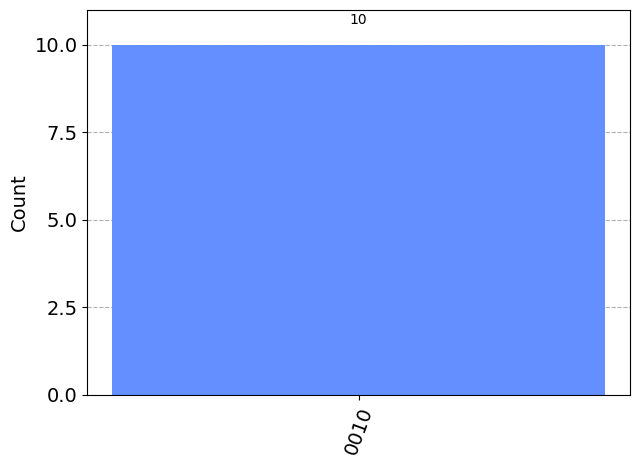

In [3]:
def incrementdown(num, borrow, circuit): # Given a quantum register of some length
    
    circuit.initialize('01', borrow) # borrow[1] (at left, initially 0) represents what is next to be borrowed
    # borrow[0] (at right, initially 1) represents the amount that needs borrowed

    for i in range(len(num)):
        circuit.cnot(borrow[0], borrow[1]) # If we have borrow now, we'll need to borrow again next time,
        circuit.toffoli(borrow[0], num[i], borrow[1]) # Unless we have one now as well.

        circuit.cnot(borrow[0], num[i]) # Perform subtraction - change number if borrowing

        circuit.swap(borrow[1], borrow[0]) # borrow from next is now our borrow;
        circuit.initialize('0', borrow[1]) # re-ground the next borrow for next time
    
myqr = QuantumRegister(4)
sum = ClassicalRegister(4)
carry = QuantumRegister(2)
myc = QuantumCircuit(myqr, sum, carry)
myc.initialize('0100', myqr) # Start with a value of b0011 = d3

incrementdown(myqr, carry, myc) # increment twice
incrementdown(myqr, carry, myc)

myc.measure(myqr, sum) # now measure

backend = Aer.get_backend('qasm_simulator')
job = execute(myc, backend, shots=10) # should always get value of b0101 = d5
result = job.result()
counts = result.get_counts()
plot_histogram(counts)


    
    

Full adder
A full adder is a decrementer when adding 111111, and an incrementer when adding 000001.  If set the first many bits with cnot gates from a Hadamard coin, have random walk.  So implement full adder.

In [ ]:
reg_length = 6

def full_add(addend1, addend2, carrybits, sumbit, circuit):
    circuit.initialize('00', carrybits) # Carry bits [0] (at right) is the carry-in
    # Carry bits[1] (at left is the carry-out)

    for i in range(reg_length): # A full adder can be done with five gates and four bits, but this way is more intuitive
        circuit.cnot(addend1[i], sumbit) # Sum is the result of three cnots (parity counter)
        circuit.cnot(addend2[i], sumbit)
        circuit.cnot(carrybits[0], sumbit)

        circuit.toffoli(addend1[i], addend2[i], carrybits[1]) # Carry-out is the result of three Toffoli gates
        circuit.toffoli(carrybits[0], addend2[i], carrybits[1])
        circuit.toffoli(addend1[i], carrybits[0], carrybits[1])

        circuit.swap(carrybits[0], carrybits[1]) # Make the carry-out the carry-in
        circuit.initialize('0', carrybits[1]) # Reset carry-out
        circuit.swap(sumbit, addend1[i]) # Store the sum in the first addend (we'll keep it)
        circuit.initialize('0', sumbit) # Reset sumbit

num = QuantumRegister(reg_length)
add = QuantumRegister(reg_length)
car = QuantumRegister(2)
sum = QuantumRegister(1)
ans = ClassicalRegister(reg_length)
circuit = QuantumCircuit(num, add, car, sum, ans)
circuit.initialize('010110', num)
circuit.initialize('000100', add)
full_add(num, add, car, sum, circuit)
circuit.measure(num, ans)

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=10) # should always get value of b0101 = d5
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
reg_length = 4

def full_add(addend1, addend2, carrybits, sumbit, circuit):
    circuit.initialize('00', carrybits) # Carry bits [0] (at right) is the carry-in
    # Carry bits[1] (at left is the carry-out)

    for i in range(reg_length): # A full adder can be done with five gates and four bits, but this way is more intuitive
        circuit.cnot(addend1[i], sumbit) # Sum is the result of three cnots (parity counter)
        circuit.cnot(addend2[i], sumbit)
        circuit.cnot(carrybits[0], sumbit)

        circuit.toffoli(addend1[i], addend2[i], carrybits[1]) # Carry-out is the result of three Toffoli gates
        circuit.toffoli(carrybits[0], addend2[i], carrybits[1])
        circuit.toffoli(addend1[i], carrybits[0], carrybits[1])

        circuit.swap(carrybits[0], carrybits[1]) # Make the carry-out the carry-in
        circuit.initialize('0', carrybits[1]) # Reset carry-out
        circuit.swap(sumbit, addend1[i]) # Store the sum in the first addend (we'll keep it)
        circuit.initialize('0', sumbit) # Reset sumbit

num = QuantumRegister(reg_length)
add = QuantumRegister(reg_length)
car = QuantumRegister(2)
sum = QuantumRegister(1)
ans = ClassicalRegister(reg_length)
coin = QuantumRegister(1)
circuit = QuantumCircuit(num, add, car, sum, ans, coin)
circuit.initialize('0'*reg_length, num)

for step in range(6): # Do this three times

    # Flip a coin
    circuit.initialize('0', coin)
    circuit.h(coin)

    # Set the last bit of my adder to one and change the rest based on the coin
    circuit.initialize('1', add[0])
    for r in range(1, reg_length):
        circuit.cnot(coin, add[r])
    
    # Add
    full_add(num, add, car, sum, circuit)

circuit.measure(num, ans)

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

More efficient
We can also use the incrementer and decrementer to be more efficient.  We can initialize the initial borrow and carry to simply be different via a Hadamard coin.

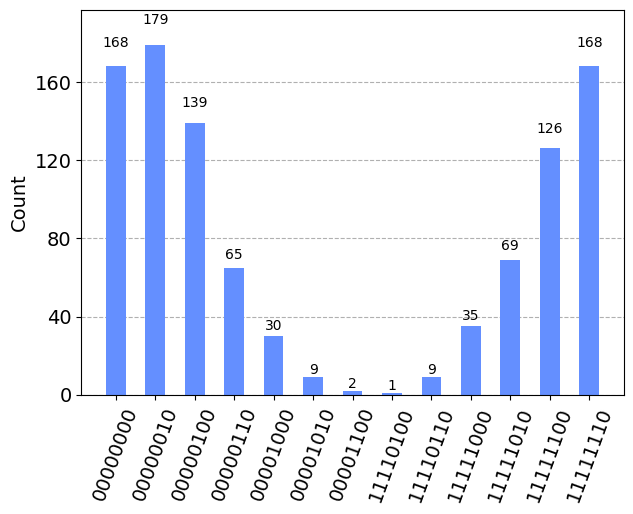

In [6]:
def incup(num, carry, circuit): # Given a quantum register of some length
    
    # circuit.initialize('01', carry) # Carry[1] (at left, initially 0) represents the next carry;
    # carry[0] (at right, initially 1) represents the input carry

    for i in range(len(num)):
        circuit.initialize('0', carry[1]) # Ground the carry bit - we want to know whether it should be one
        circuit.toffoli(carry[0], num[i], carry[1]) # Find the next carry - it's one iff both input carry and bit are one
        circuit.cnot(carry[0], num[i]) # Increment - change the value if there is carry
        circuit.swap(carry[0], carry[1]) # And next carry becomes new input carry

def incdown(num, borrow, circuit): # Given a quantum register of some length
    
    # circuit.initialize('01', borrow) # borrow[1] (at left, initially 0) represents what is next to be borrowed
    # borrow[0] (at right, initially 1) represents the amount that needs borrowed

    for i in range(len(num)):
        circuit.initialize('0', borrow[1]) # Ground the next borrow for next time

        circuit.cnot(borrow[0], borrow[1]) # If we have borrow now, we'll need to borrow again next time,
        circuit.toffoli(borrow[0], num[i], borrow[1]) # Unless we have one now as well.

        circuit.cnot(borrow[0], num[i]) # Perform subtraction - change number if borrowing

        circuit.swap(borrow[1], borrow[0]) # borrow from next is now our borrow;

reg_length = 8
num = QuantumRegister(reg_length)
car = QuantumRegister(2)
bor = QuantumRegister(2)
ans = ClassicalRegister(reg_length)
circuit = QuantumCircuit(num, car, bor, ans)
circuit.initialize('0'*reg_length, num)

for step in range(16):

    # Set bor[0] and car[0] to be opposite each other
    circuit.initialize('0', bor[0])
    circuit.initialize('1', car[0])
    circuit.h(bor[0])
    circuit.cnot(bor[0], car[0])

    # Take a step
    incdown(num, bor, circuit)
    incup(num, car, circuit)

circuit.measure(num, ans) # View results

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

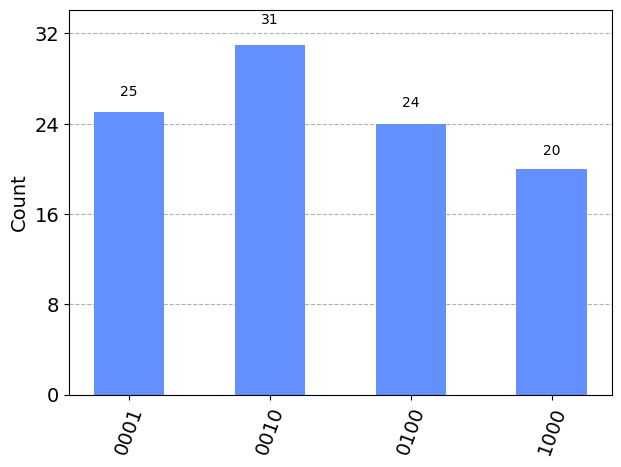

In [5]:
def decode2to4(circuit, in_r, out_r):
    circuit.initialize('0000', out_r)

    circuit.x(out_r[0])
    circuit.cx(in_r[0], out_r[0])
    circuit.cx(in_r[1], out_r[0])
    circuit.toffoli(in_r[0], in_r[1], out_r[0])

    circuit.cx(in_r[0], out_r[1])
    circuit.toffoli(in_r[0], in_r[1], out_r[1])

    circuit.cx(in_r[1], out_r[2])
    circuit.toffoli(in_r[0], in_r[1], out_r[2])

    circuit.toffoli(in_r[0], in_r[1], out_r[3])

def flip_coins(circuit, coins):
    circuit.initialize('0'*len(coins), coins)
    for c in coins:
        circuit.h(c)

coins = QuantumRegister(2)
choice = QuantumRegister(4)
choice_show = ClassicalRegister(4)
circuit = QuantumCircuit(coins, choice, choice_show)

# circuit.initialize('00', coins)
# circuit.h(coins[0])
# circuit.h(coins[1])
flip_coins(circuit, coins)
decode2to4(circuit, coins, choice)
circuit.measure(choice, choice_show)

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)


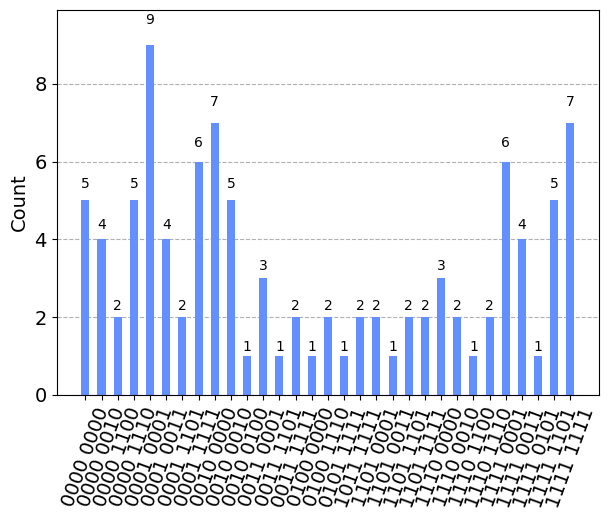

In [8]:
# Biaxial version
axis_length = 4 # In qubits; e.g., 4 is 16
steps = 8

coins = QuantumRegister(2)
choice = QuantumRegister(4)
ancil = QuantumRegister(4)
x_qr = QuantumRegister(axis_length)
y_qr = QuantumRegister(axis_length)
x_cr = ClassicalRegister(axis_length)
y_cr = ClassicalRegister(axis_length)
biaxircuit = QuantumCircuit(coins, choice, ancil, x_qr, y_qr, x_cr, y_cr)

for s in range(steps):
    flip_coins(biaxircuit, coins)
    decode2to4(biaxircuit, coins, choice)

    incup(x_qr, [choice[0], ancil[0]], biaxircuit)
    incdown(x_qr, [choice[1], ancil[1]], biaxircuit)
    incup(y_qr, [choice[2], ancil[2]], biaxircuit)
    incdown(y_qr, [choice[3], ancil[3]], biaxircuit)

biaxircuit.measure(x_qr, x_cr)
biaxircuit.measure(y_qr, y_cr)

job = execute(biaxircuit, backend, shots=100)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)
    
    

